In [16]:
from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla_encoder import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.power.data.meteo import PFDInterFace, ecmwf_new_energy_args, cma_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.power.data.tr import TRInterFace

from finance_utils.electrical2.spot.probabilistic.forecast.power.forecast.gridtwicecook import GridTwiceCookedEncoder


from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData, new_or_cat,new_or_stack
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import os
import numpy
import pickle
import tqdm
from easy_datetime.timestamp import TimeStamp


from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster



import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [17]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

with open(f"{root}\\shanxi_1.pfd", "rb") as f:
    pfd: ProvinceForecastData = pickle.loads(f.read())

In [18]:
target_day = TimeStamp("2024-10-22")
train_day_1 = TimeStamp(target_day) - ["day", 2]
train_day_2 = TimeStamp(target_day) - ["day", 1]
train_power_1 = TRInterFace.hourly_actual_range("shanxi", train_day_1.get_date_string(), train_day_1.get_date_string())["power"]
train_power_2 = TRInterFace.hourly_actual_range("shanxi", train_day_2.get_date_string(), train_day_2.get_date_string())["power"]
test_power = TRInterFace.hourly_actual_range("shanxi", target_day.get_date_string(), target_day.get_date_string())["power"]
mf = PFDInterFace.directed_forecast(pfd, train_day_1.get_date_string(), ["cma", "evening"], 9)
# [TimeStamp(i) for i in mf[0][:,1]]
# mf
# [TimeStamp(i) for i in power.x]
# y = numpy.tile(power, len(mf))

In [19]:
# tm, tl = PFDInterFace.time_periodic_encoding(mfa, 7, False)
# ntm = PFDInterFace.norm_by_meteo_key(tm, ZScore, cma_new_energy_args, tl)
# tm[:,:tl]
tml = []
for i in mf:
    tm,tl = PFDInterFace.time_periodic_encoding(i, 7)
    tml.append(
        PFDInterFace.norm_by_meteo_key(tm, ZScore, cma_new_energy_args, tl)
    )



100%|██████████| 1134/1134 [00:00<00:00, 39067.42it/s]


In [20]:
# input_size = gmf[0].shape[1]
d_model = 128
dim_feedforward = 2048
nhead = 2
output_size = 1
# num_layers = 4
num_layers = 4
# batch_size = fore_days * 4
# batch_size = fore_days // 24//3600 * 4
batch_size = 6
lr = 1e-3

yp = ZScore.params(train_power_1)
y = ZScore.f(train_power_1)

trained_model_list = []
for i,tm in enumerate(tml):
    input_size = tm.shape[1]
    m = VanillaTransformerEncoder(
        input_size=input_size,
        output_size=output_size,
        num_layers=num_layers,
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    )
    trained_model_list.append(
        vanilla_transformer_trainer2(m, torch.Tensor(tm), torch.Tensor(y), batch_size, epochs=50, lr=lr, loser=nn.L1Loss, shuffle=True)
    )
    

100%|██████████| 50/50 [00:01<00:00, 35.94it/s]


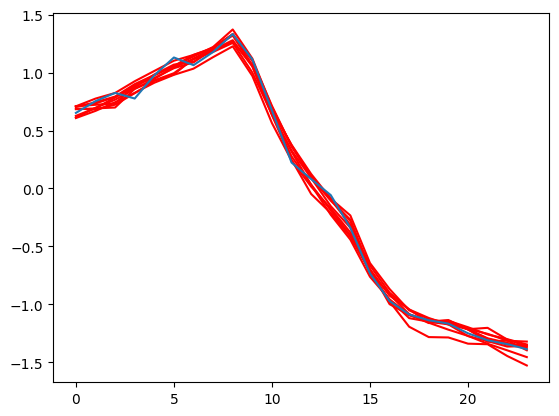

In [21]:
for i,m in enumerate(trained_model_list):
    p = vanilla_transformer_tester(m, torch.Tensor(tml[i]), batch_size)
    plt.plot(p.reshape(-1).cpu().numpy(), color="red")
plt.plot(y)

In [22]:
mf2 = PFDInterFace.directed_forecast(pfd, train_day_2.get_date_string(), ["cma", "evening"], 9)
tml2 = []
for i in mf2:
    tm,tl = PFDInterFace.time_periodic_encoding(i, 7)
    tml2.append(
        PFDInterFace.norm_by_meteo_key(tm, ZScore, cma_new_energy_args, tl)
    )

100%|██████████| 1134/1134 [00:00<00:00, 40463.31it/s]


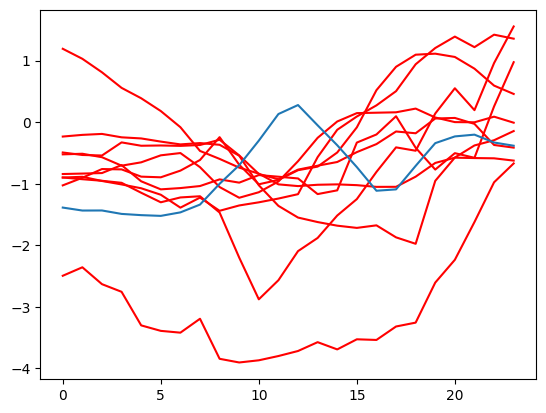

In [23]:
m1_p_l = []
for i,m in enumerate(trained_model_list):
    p = vanilla_transformer_tester(m, torch.Tensor(tml2[i]), batch_size)
    m1_p_l.append(p.reshape(-1).cpu().numpy())
    plt.plot(p.reshape(-1).cpu().numpy(), color="red")
plt.plot(ZScore.f_with_params(train_power_2, yp))

In [24]:
m1_p_a = numpy.array(m1_p_l).T
m1_param = []
for i in range(m1_p_a.shape[1]):
    m1_param.append(ZScore.params(m1_p_a[:,i]))
    m1_p_a[:,i] = ZScore.f(m1_p_a[:,i])

m2 = VanillaTransformerEncoder(
    input_size=m1_p_a.shape[1],
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)
tained_m2 = vanilla_transformer_trainer2(m2, torch.Tensor(m1_p_a), torch.Tensor(ZScore.f(train_power_2)), batch_size, epochs=50, lr=lr, loser=nn.L1Loss, shuffle=True)

100%|██████████| 50/50 [00:01<00:00, 35.40it/s]


In [25]:
mf3 = PFDInterFace.directed_forecast(pfd, target_day.get_date_string(), ["cma", "evening"], 9)
tml3 = []
for i in mf3:
    tm,tl = PFDInterFace.time_periodic_encoding(i, 7)
    tml3.append(
        PFDInterFace.norm_by_meteo_key(tm, ZScore, cma_new_energy_args, tl)
    )

100%|██████████| 1134/1134 [00:00<00:00, 41962.28it/s]


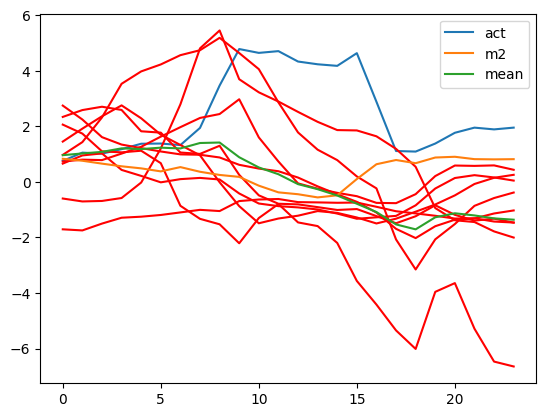

In [32]:
m2_p_l = []
for i,m in enumerate(trained_model_list):
    p = vanilla_transformer_tester(m, torch.Tensor(tml3[i]), batch_size)
    m2_p_l.append(p.reshape(-1).cpu().numpy())
    # plt.plot(p.reshape(-1).cpu().numpy(), color="red")
plt.plot(ZScore.f_with_params(test_power, ZScore.params(train_power_2)), label="act")

m2_p_a = numpy.array(m2_p_l).T
for i in range(m2_p_a.shape[1]):
    m2_p_a[:,i] = ZScore.f_with_params(m2_p_a[:,i], m1_param[i])
    plt.plot(m2_p_a[:,i], color="red")


plt.plot(
    vanilla_transformer_tester(tained_m2, torch.Tensor(m2_p_a), batch_size).reshape(-1).cpu().numpy(), label="m2"
)
plt.plot(numpy.apply_along_axis(numpy.mean, axis=1, arr= m2_p_a), label="mean")
plt.legend()
plt.show()
